In [177]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline

# Define system dynamics and measurements
This example uses a simple 2-state linear system with a single nonlinear measurement. The system corresponds to a single downward pointed camera moving in the horizontal direction. This is similar, but slightly different, from the example discussed in the following reference:

Floris van Breugel, Kristi Morgansen, and Michael H Dickinson
Monocular distance estimation from optic flow during active landing maneuvers.
Bioinspiration & Biomimetics, Volume 9, Number 2
DOI 10.1088/1748-3182/9/2/025002

The system dynamics are described by two states:
* ground speed $g$
* distance above the ground $d$

$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{g} \\ \dot{d} \end{bmatrix} = f(\mathbf{x}) = \begin{bmatrix} u \\ 0 \end{bmatrix}
$$

The system measurements are given by the ventral optic flow:
* $r = g/d$

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} g/d \end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [178]:
state_names = ['g', 'd']  # optional to specify state names
input_names = ['u'] # optional to specify input names
def f(X, U):
    # States
    g, d = X

    # Inputs
    u = U[0]

    # Dynamics
    g_dot = u
    d_dot = 0*u

    # Package and return xdot
    x_dot = [g_dot, d_dot]

    return x_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [179]:
measurement_names = ['r']  # optional to specify measurement names
def h(X, U):
    # States
    g, d = X

    # Inputs
    u = U

    # Measurements
    Y = [g/d]

    # Return measurement
    return Y


## Set time-step

In [180]:
dt = 0.01  # [s]

# Create simulator object
Given $f$ & $h$ make a simulator object to simulate the system

In [181]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names, )

# Can also set the number of state (n) & inputs (m0 instead of state & input names
# simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Set inputs
This can be done in open-loop where the inputs $\mathbf{u}$ are set directly, or with a control law that chooses $\mathbf{u}$.
In this example we can use open-loop or use model predictive control (MPC) to follow a given set-point for ground speed.

### Model-predictive control

In [182]:
# First define the set-point(s) to follow
tsim = np.arange(0, 8.0, step=dt)
setpoint = {'g': 0.1 + 1.0*np.sin(2*np.pi*tsim*0.3),  # ground speed changes as a sinusoid
            'd': 0.5*np.ones_like(tsim)}

In [183]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [184]:
# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost = (simulator.model.x['g'] - simulator.model.tvp['g_set']) ** 2

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(u=1e-12)

In [185]:
# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

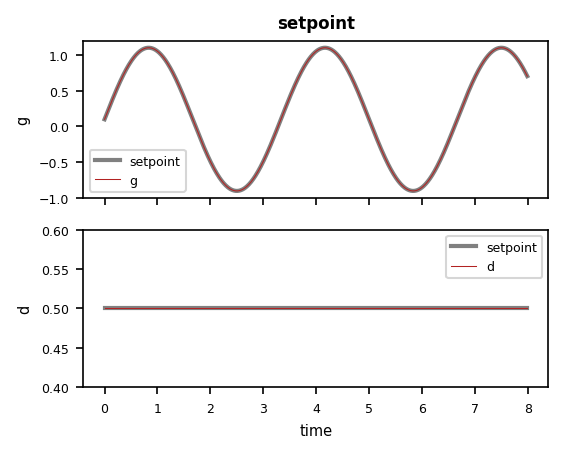

In [186]:
# Plot the states vs the set-points
simulator.plot('setpoint')

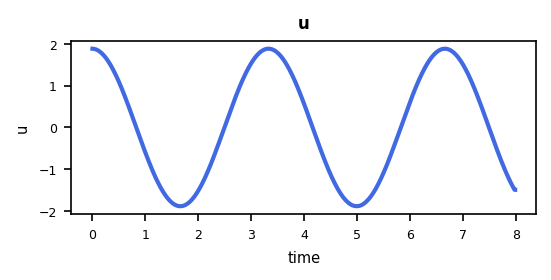

In [187]:
# Plot the inputs
simulator.plot('u')

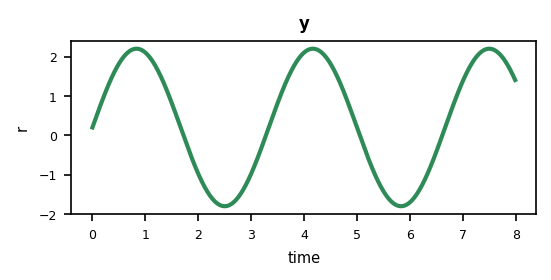

In [188]:
# Plot the outputs
simulator.plot('y')

### Open-loop

In [189]:
use_open_loop = True  # set to False to use the MPC state trajectory above, or True to use the open-loop inputs below

In [190]:
if use_open_loop:
    # Set initial state
    x0 = {'g': 2.0, 'd': 3.0}
    
    # Set open-loop inputs directly
    tsim1 = np.arange(0, 3, step=dt)
    tsim2 = np.arange(3, 6, step=dt)
    tsim3 = np.arange(6, 9, step=dt)
    tsim = np.hstack((tsim1, tsim2, tsim3))
    
    u1 = np.sin(3*tsim1)
    u2 = 1e-5*np.sin(3*tsim2)
    u3 = np.sin(3*tsim3)
    u = np.hstack((u1, u2, u3))
    
    # Can also set as dict
    u = dict(u=u)
    
    # Run simulation using open-loop inputs
    t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0, u=u, return_full_output=True)


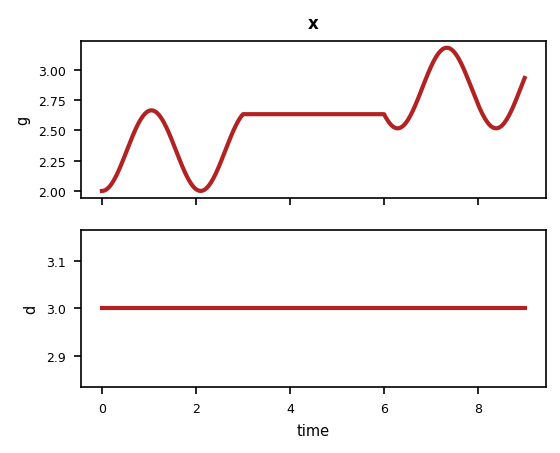

In [191]:
# Plot the states
simulator.plot('x')

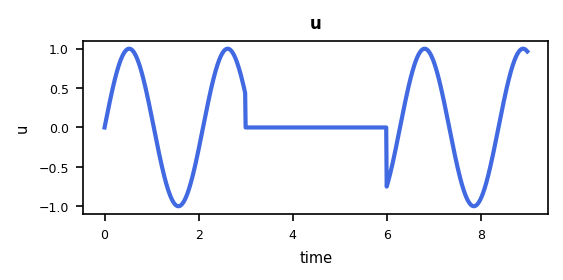

In [192]:
# Plot the inputs
simulator.plot('u')

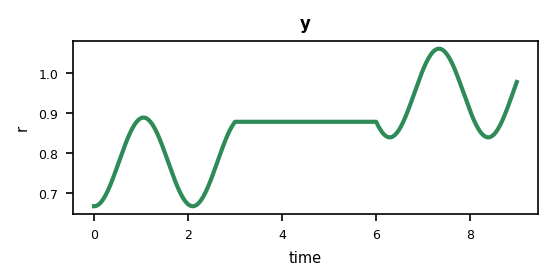

In [193]:
# Plot the outputs
simulator.plot('y')

# Observability

## Construct observability matrix in sliding windows

In [194]:
w = 6  # window size, set to None to use entire time-series as one window

In [195]:
# Construct O in sliding windows
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

In [196]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [197]:
n_window = len(O_sliding)
print(n_window, 'windows')

895 windows


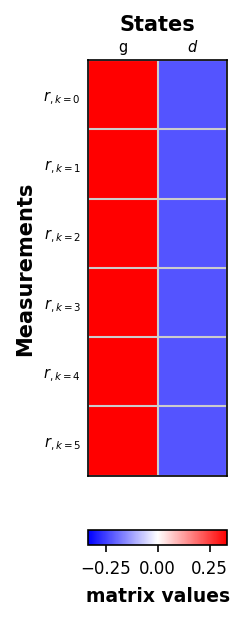

In [198]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=2.0)

## Compute Fisher information matrix & inverse for first window


In [199]:
# Set each sensor noise level
R = {'r': 0.1}

In [200]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R, lam=1e-8)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [201]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,g,d
g,497967.344844,7.465779e+05
d,746577.912149,1.119308e+06


## Compute Fisher information matrix & inverse for each sliding window

In [202]:
# Choose sensors to use from O
o_sensors = ['r']

# Chose states to use from O
o_states = ['g', 'd']

# Choose time-steps to use from O
window_size = 6
o_time_steps = np.arange(0, window_size, step=1)

In [203]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=R,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [204]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

# Plot error variance as color on state time-series

In [205]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

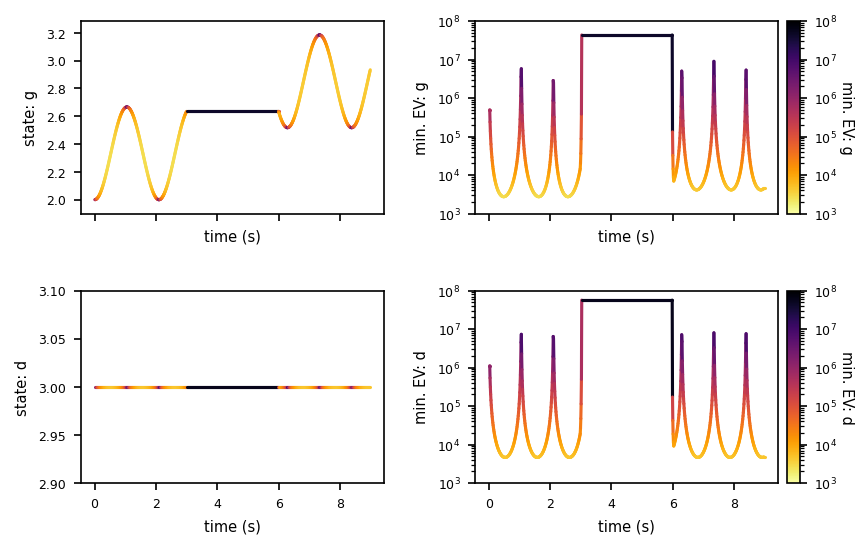

In [206]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)
    
    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.1, x_max + 0.1)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)